In [19]:
from etl.load_data import data_sources,create_train_test_val
from eda.plotly_plots import Plot
from etl.cleaning import RemoveOutlierData
from etl.feature_generation import GenerateFeatures
from modeling.base_model import BaselineModel
from modeling.nn_model import NNmodel

import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn

import plotly.offline as pyo

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pyo.init_notebook_mode()

%load_ext autoreload
%autoreload 2

# Outline of the approach

### 1. Explore the data provided
### 2. Check the data for outlier and seasonality 
### 3. Create features 
### 4. Create the baseline model 
### 5. Use advance model and run the model diagnoistics and evaluation
### 5. Deploy the model from AWS sagmaker using lambda functions and expose API using API gateway
### 6. Give Details of next steps and further optimisation techniques to explore 

# Load the data and correct the data type

In [9]:
data = data_sources()

In [10]:
data.orders.head()

order_acknowledged_at                   order_ready_at  \
0 2015-06-01 11:28:28.952789+00:00 2015-06-01 13:12:09.474896+00:00   
1 2015-06-06 16:06:24.434807+00:00 2015-06-06 16:16:27.520253+00:00   
2 2015-06-08 13:56:15.503204+00:00 2015-06-08 14:03:39.397496+00:00   
3 2015-06-12 14:12:20.497925+00:00 2015-06-12 14:23:30.064683+00:00   
4 2015-06-01 12:07:10.794050+00:00 2015-06-01 13:02:25.104517+00:00   

   order_value_gbp  restaurant_id  number_of_items  prep_time_seconds  
0            59.90           1326                2               6220  
1            24.00           1326                8                603  
2            15.25           1326                3                443  
3            28.05           1326                8                669  
4            56.30            255                7               3314

In [5]:
data.orders.columns

(32394, 6)

In [11]:
data.restaurants.columns

Index(['restaurant_id', 'country', 'city', 'type_of_food'], dtype='object')

In [33]:
data.restaurants.head()

restaurant_id country    city type_of_food
0              3      UK  London         thai
1              5      UK  London      italian
2              7      UK  London      italian
3              8      UK  London      chinese
4              9  France   Paris       korean

In [7]:
data.orders.describe()

order_value_gbp  restaurant_id  number_of_items  prep_time_seconds
count     32394.000000   32394.000000     32394.000000       32394.000000
mean         26.547303    1290.555535         4.025715        1299.993857
std          19.263851     960.295504         2.392063        4404.573191
min           0.500000       3.000000         1.000000           0.000000
25%          16.700000     408.000000         3.000000         518.000000
50%          21.400000    1160.000000         3.000000         820.000000
75%          30.250000    2117.000000         5.000000        1227.000000
max         711.000000    3622.000000        38.000000      255499.000000

# EDA on orders data

### Creating additional variables to explore the data

In [12]:
# average price per item for the restaurant (a proxy for the type of restaurant)
orders = data.orders.copy()

orders['value_per_item'] = orders['order_value_gbp'] / orders['number_of_items']

# hour of the day for the order (kitchens will have busier and less busy times)
orders['hour_order_acknowledged_at'] = orders['order_acknowledged_at'].dt.hour

# day of the week for the order (kitchens will have busier and less busy times)
orders['day_of_order'] = orders['order_acknowledged_at'].dt.dayofweek #  Monday=0, Sunday=6.

## number of orders per restaurant
orders_grouped_count = orders.groupby(by='restaurant_id').count()['number_of_items'] #dummy var for aggregation

## Median of orders per restaurant
orders_grouped_median = orders.groupby(by='restaurant_id').median()[['order_value_gbp', 'number_of_items', 'value_per_item']]
orders_grouped_median.columns  = ["median_" +col +"_per_restaurants" for col in orders_grouped_median.columns]
orders_grouped_median['count_number_of_items_per_restaurants'] = orders_grouped_count



## There is a lot of skewness in the distribution of Order Value and Number of Items which suggests we need to apply capping and binning or removing the outlier values



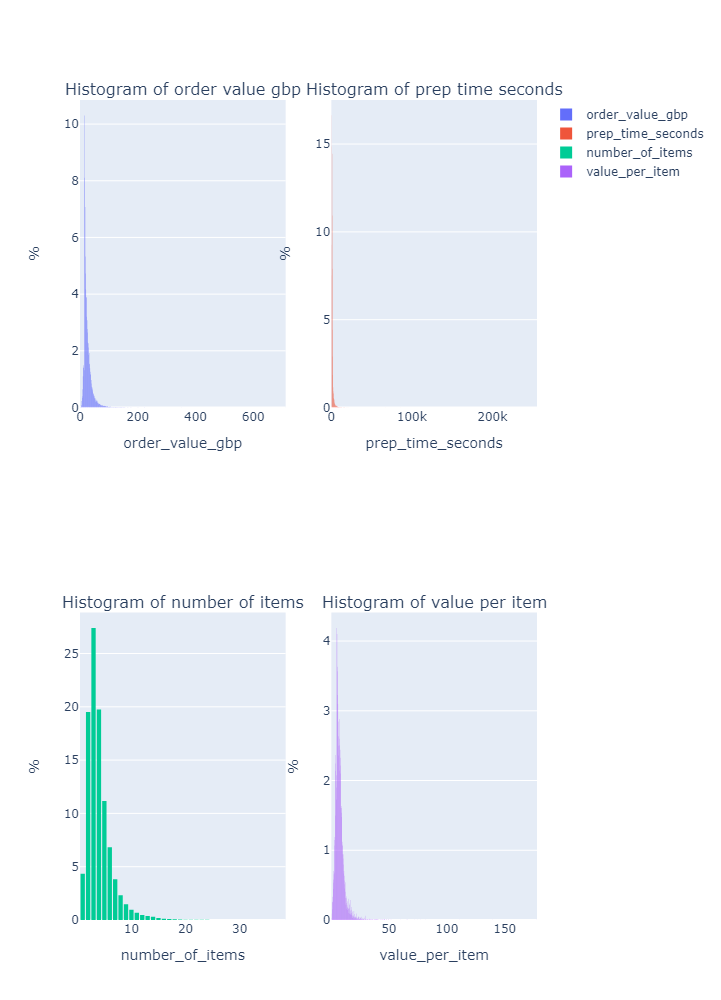

In [13]:
Plot.PlotHistogram(orders,['order_value_gbp','prep_time_seconds','number_of_items','value_per_item'])

# Seasonality impact

## there is clear impact of seasonality in the data  the orders are higher over the weekend and between 18-22 hours
## The Median Prep Time (target Variable also varies with the Time of Day and the Day of the week)

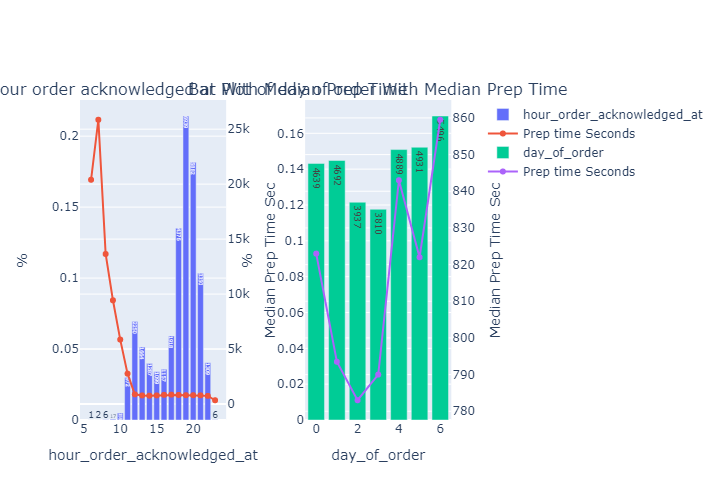

In [16]:
Plot.PlotBarWithPrepTime(orders,['hour_order_acknowledged_at','day_of_order'],sort_values = True)

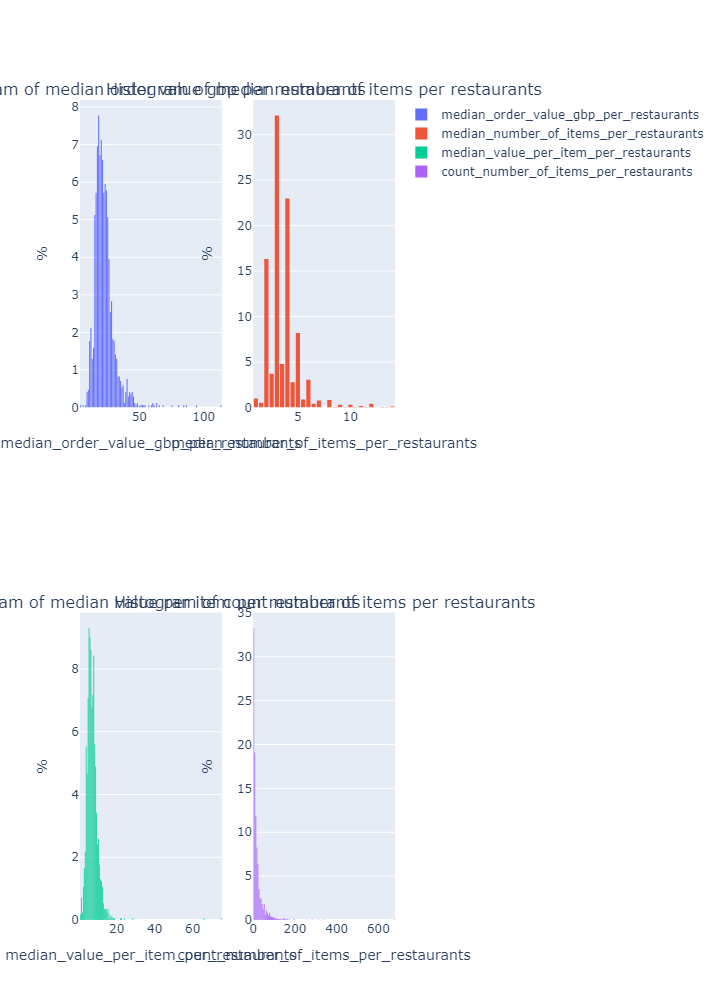

In [9]:
Plot.PlotHistogram(orders_grouped_median,['median_order_value_gbp_per_restaurants',
                                          'median_number_of_items_per_restaurants','median_value_per_item_per_restaurants','count_number_of_items_per_restaurants'])

# EDA on the Restaurants Table

## There is a lot of skewness in the distribution of Restaurants most of them are concentrated in london and capital cities 

## The type of food is very messy has a lot of overlaping food types e.g lebanese french and lebanese moroccon (can be reduced using semantic matching)

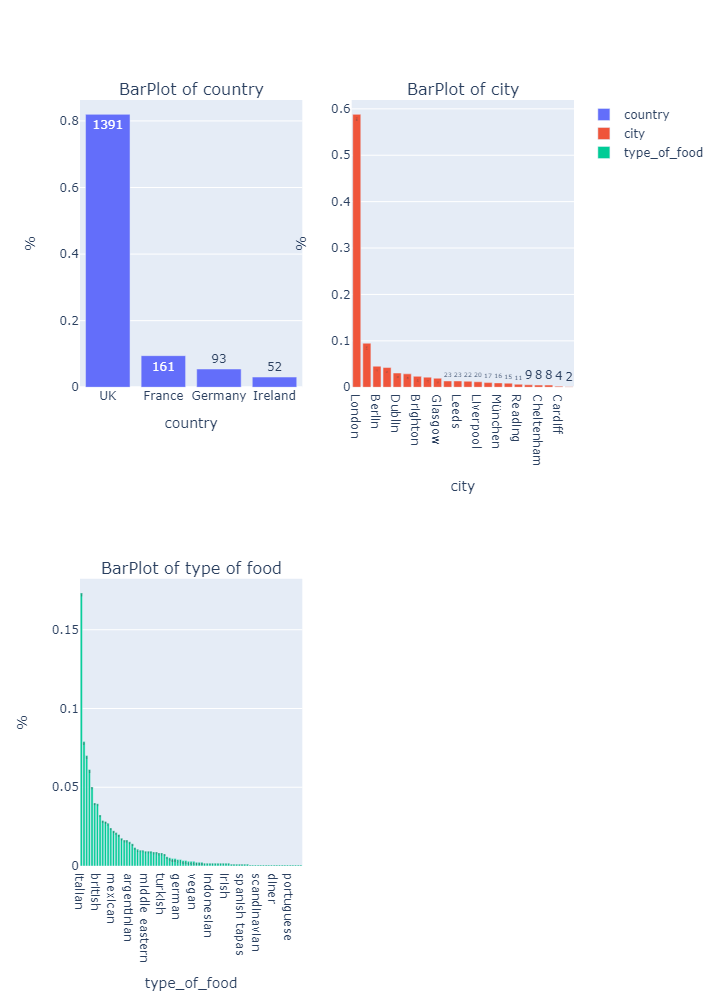

In [18]:
Plot.PlotBar(data.restaurants,['country','city','type_of_food'])

# EDA on the combined data (joining order and restaurant df)

## The transaction in London area is higher hence skewing the transction in its direction

In [7]:
# Combining the dataset :
combined_data = data.merge_order_restaurants()  
combined_data.head()

order_acknowledged_at                   order_ready_at  \
0 2015-06-01 11:28:28.952789+00:00 2015-06-01 13:12:09.474896+00:00   
1 2015-06-06 16:06:24.434807+00:00 2015-06-06 16:16:27.520253+00:00   
2 2015-06-08 13:56:15.503204+00:00 2015-06-08 14:03:39.397496+00:00   
3 2015-06-12 14:12:20.497925+00:00 2015-06-12 14:23:30.064683+00:00   
4 2015-06-01 12:07:10.794050+00:00 2015-06-01 13:02:25.104517+00:00   

   order_value_gbp  restaurant_id  number_of_items  prep_time_seconds country  \
0            59.90           1326                2               6220      UK   
1            24.00           1326                8                603      UK   
2            15.25           1326                3                443      UK   
3            28.05           1326                8                669      UK   
4            56.30            255                7               3314      UK   

     city type_of_food  
0  London     burritos  
1  London     burritos  
2  London     burritos  
3  London     burritos  
4  London      chinese

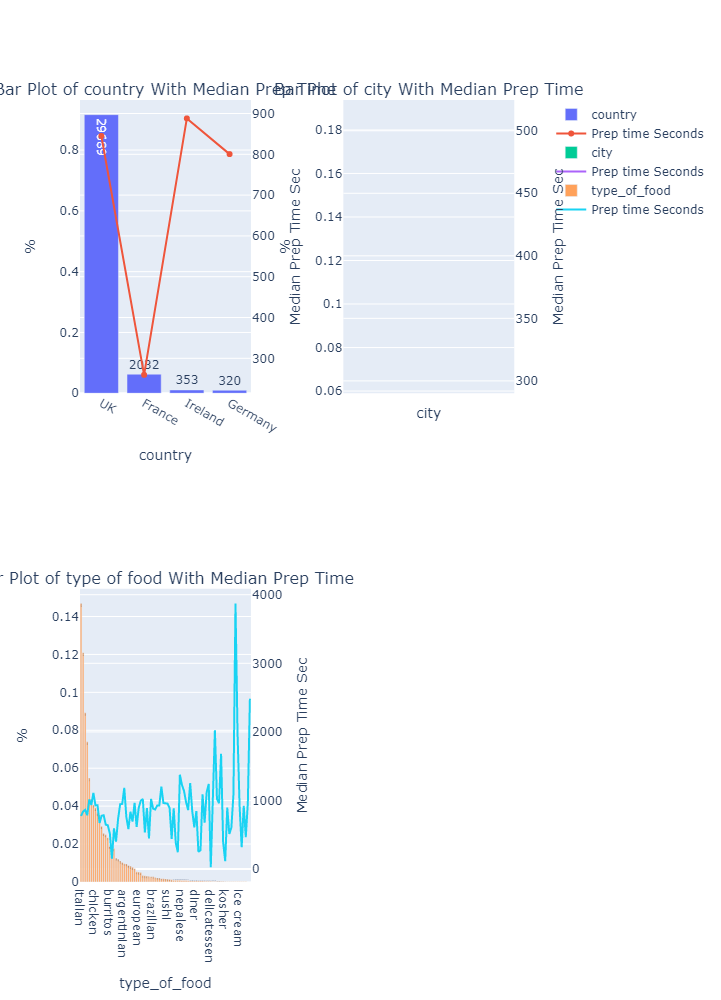

In [12]:
Plot.PlotBarWithPrepTime(combined_data,feature_list=['country','city','type_of_food'],sort_values = False)

# Feature Generation
### based on the above EDA creating the below features to be inputed in the model

### value per item
### hour of the day
### week of the day
### Median value of the above features (created after splitting into test and train and validation to avoid leakage)

In [9]:
combined_data = GenerateFeatures.generate_order_features(combined_data)

# Clean the data

## Cap the value of the the orders and max_value to the 99th percentile (can be varied and results checked)
## Remove the data points with prep_time > 99th percentile. could be due to problem at the restaurant or error in registering the order
## Remove the orders where the location and type of food has been ordered less than 100 times (using default prediction in these scenario's is more usefull and stable)

In [10]:
max_prep_time = combined_data['prep_time_seconds'].quantile(.99)
print("Max Prep Time :",max_prep_time)

max_order_value = combined_data['order_value_gbp'].quantile(.99)
print("Max Order value :",max_order_value)

max_number_of_items= combined_data['number_of_items'].quantile(.99)
print("Max Number of Items:",max_number_of_items)


Max Prep Time : 7634.209999999999
Max Order value : 96.20349999999999
Max Number of Items: 13.0


In [11]:
combined_data = RemoveOutlierData.cap_bin_orders_data(orders =combined_data,
                                      max_items=max_number_of_items,
                                      max_value=max_order_value)

combined_data = RemoveOutlierData.filter_orders_data(combined_data,
                                                     max_prep_seconds=max_prep_time)

combined_data = RemoveOutlierData.filter_on_location_and_food_type(combined_data)

size of orders after removals 32070
final size of dataset after filtering (30616, 13)


# Creating the first baseline

### We will create a simple Ridge model to create a baseline and understand the impact of some of the features 

In [12]:
# Splitting the data 80:20 where 20% will be the hold out dataset
final_data = create_train_test_val(combined_data)

24492 train examples
6124 test examples


In [13]:
#Sgaemaker Session
sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()


#S3 bucket
s3_prefix = 'restaurant-poc'
traindata_s3_prefix = '{}/data/train'.format(s3_prefix)
combined_data_file = 'combined_data.csv'

# Convert the dataframe to a CSV file
combined_data.to_csv(combined_data_file, index=False)
train_s3 = sagemaker.Session().upload_data(combined_data_file, key_prefix=traindata_s3_prefix)


In [22]:
script_path = 'train.py'

sklearn = SKLearn(
    entry_point=script_path,
    instance_type="ml.m4.xlarge",
    framework_version="0.20.0",
    py_version="py3",
    role=role,
    sagemaker_session=sagemaker_session)

In [39]:
sklearn.fit({'train': train_s3})


2023-01-11 17:53:14 Starting - Starting the training job...ProfilerReport-1673459594: InProgress
...
2023-01-11 17:54:08 Starting - Preparing the instances for training.........
2023-01-11 17:55:29 Downloading - Downloading input data..2023-01-11 17:55:50,975 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-01-11 17:55:50,978 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-01-11 17:55:50,988 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-01-11 17:55:51,191 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-01-11 17:55:51,205 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-01-11 17:55:51,219 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-01-11 17:55:51,230 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_pa

In [40]:
#Deploy model
deployment = sklearn.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

------!

In [41]:
deployment.endpoint

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'sagemaker-scikit-learn-2023-01-11-17-57-00-320'

In [17]:
# Creating the dummy variables 
base_model = BaselineModel(final_data,vars_to_keep=['order_value_gbp',
                                              'number_of_items',
                                              'country',
                                              'city',
                                              'type_of_food',
                                              'value_per_item',
                                              'hour_order_acknowledged_at',
                                              'day_of_order'])

normalize the data
train dummies shape 72
test dummies shape 72
create the linear model using ridge with alpha 2


# Feature Importance and Business Impact

The Baseline mode clearly shows the that the location has and time (seasonlity has a very heavy impact on the ood preparation times)

Type of food as expected also has a big impact with Indian , Japanese , Korean increasing prep time while Burritos ,dessert and french taking lesse time

As expected non peak times take lesser prep times (due to low volume of orders)

We also see increased impact of weekend was detected by the model as well (Frid-Sund) (but not strong enough)

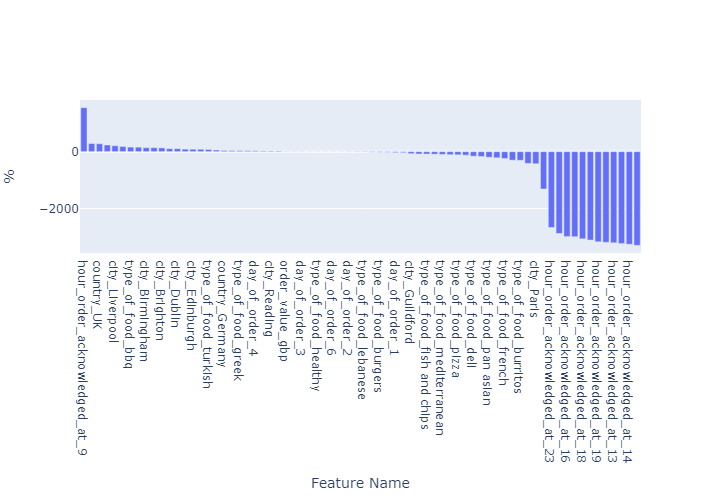

In [18]:
base_model.plot_variable_importance()

In [19]:
# print the train statistics
print("Train Statistics")
base_model.print_evaluation_statistics(train = True)

# print the test statistics
print("Test Statistics")
base_model.print_evaluation_statistics(train = False)

Train Statistics
Mean Absolute Error : 479.1744937664163
Mean Square Error : 584913.9889490635
Test Statistics
Mean Absolute Error : 481.4418384448766
Mean Square Error : 613224.8889474527


## Given we have some very high cardinality dataset (type_of_food,restaurant_id) it might be beneficial to use entity embeddings for the variables and use a DNN (deep Neural Net) to capture the non-linearity in the dataset

In [20]:
final_data = GenerateFeatures.restaurant_feature_generation_from_orders(final_data)

NUMERIC_FEATURES = ['rest_median_order_value_gbp', 'rest_median_number_of_items',
            'rest_median_value_per_item', 'number_of_items', 'order_value_gbp','value_per_item']

for col in NUMERIC_FEATURES:
    final_data.train[col] = final_data.train[col].astype(float)
    final_data.test[col] = final_data.test[col].astype(float)


shape of original train data 24492
shape of original test data 6124
shape of train data after transformation 24492
shape of test data after transformation 6079


In [21]:


feature_names = ['order_value_gbp', 'value_per_item','number_of_items', 'hour_order_acknowledged_at',
                    'country', 'city', 'type_of_food', 'day_of_order', 'restaurant_id',
                    'rest_median_order_value_gbp', 'rest_median_number_of_items',
                    'rest_median_value_per_item']

nnmodel = NNmodel(final_data,combined_data,feature_names)

create Features to feed in the DL model


In [22]:
nnmodel.model_fit_and_evaluate(100)

Epoch 1/100
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Use `tf.cast` instead.
613/613 - 21s - loss: 1715107.2927 - mae: 977.8473 - mse: 1730742.8306 - val_loss: 1214871.8590 - val_mae: 730.7403 - val_mse: 1220145.5000
Epoch 2/100
613/613 - 22s - loss: 918689.0532 - mae: 600.0084 - mse: 972747.2364 - val_loss: 703868.1333 - val_mae: 515.5709 - val_mse: 707282.1875
Epoch 3/100
613/613 - 19s - loss: 824819.0662 - mae: 543.8984 - mse: 784903.1947 - val_loss: 680926.8649 - val_mae: 502.5802 - val_mse: 684297.5000
Epoch 4/100
613/613 - 18s - loss: 797657.9155 - mae: 528.6763 - mse: 760802.1268

### DL Results
#### test_loss 553945.0411800987
#### test mae 427.9782
#### test mse 553781.25

# We get a ~15% improvement in both the MAE and MSE using the DNN model which shows there is non-linearity in the dataset 

# Other things to try
 
### We did not perform extensive hyper parameter tuning which could further improve the accuracy.
### Evaluate the feature importance using model agnotic techniques such as SHAP values.
### Try Tree based ensemble models as they work on structured data really well.
### Using K-Folds cross validation to confirm whether the model is stable.
### try different feature cleaning technique and see the impact on the model
### Further clean the type_of_food column as that categories can be collapsed and aggregrated (e.g burritos and mexican)

# Next steps

### This model has many real time applications such as alerting the rider by when the order is going to prepared so to reach the restaurant accordingly and giving an estimate to the customer by when the order will be prepared before placing the order

### Since the mostly use case would mean integration in the App, tune the model considering inference time (choose a Tree Based model instead of DL model incase perfromace is similar,reduce the datatype size of stored model)


In [3]:
#loading the last checkpoint data
m = nnmodel.model_building()
m.load_weights('model_weights/weights.cpkt')